In [1]:
import pathlib

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.svm import OneClassSVM
import tensorflow.keras as keras

from common import *

In [2]:
SR = 22050
FRAME_LENGTH = 2048
HOP_LENGTH = 512


sample_duration = 1 / SR
f"{sample_duration:6f} seconds per sample"

'0.000045 seconds per sample'

In [3]:
FRAME_LENGTH * sample_duration   # frame length in seconds

0.046439909297052155

In [4]:
# read in all the data relevant to NAMES
df = pd.concat(pd.read_csv(dataset, sep="\t") for dataset in GOOGLE_AUDIO_DATASETS)
labels = LABEL_TO_NAME_DF["label"][LABEL_TO_NAME_DF["name"].isin(NAMES)]
df = pd.merge(LABEL_TO_NAME_DF, df[df["label"].isin(labels)].drop_duplicates())
df

,label,name,segment_id,start_time_seconds,end_time_seconds
0,/m/01280g,Wild animals,Nsjm00Bwebo_140000,0.937,1.283
1,/m/01280g,Wild animals,Nsjm00Bwebo_140000,1.598,1.811
2,/m/01280g,Wild animals,Nsjm00Bwebo_140000,6.110,8.803
3,/m/01280g,Wild animals,EWa3Sn05r9s_30000,0.000,10.000
4,/m/01280g,Wild animals,F1qVm133XJg_250000,1.976,2.394
...,...,...,...,...,...
13123,/m/0jb2l,Thunderstorm,FxQPQrclApE_80000,0.000,2.196
13124,/m/0jb2l,Thunderstorm,FxQPQrclApE_80000,2.993,10.000
13125,/m/0jb2l,Thunderstorm,2Gdc-JF2tp8_30000,8.807,10.000
13126,/m/0jb2l,Thunderstorm,ZwuaEMb0k38_50000,7.009,10.000


In [5]:
# keep only those which are present on disk
on_disk_df = pd.DataFrame([p.parts[-2:] for p in AUDIO_DIR.glob("*/*.mp3")], columns=["name", "segment_id"])
on_disk_df["segment_id"] = on_disk_df["segment_id"].str.slice(stop=-4)
df = pd.merge(on_disk_df, df)
df

,name,segment_id,label,start_time_seconds,end_time_seconds
0,Wild animals,SNdxshiRXmE_20000,/m/01280g,0.000,10.000
1,Wild animals,oSAId-oADL8_110000,/m/01280g,0.054,0.282
2,Wild animals,oSAId-oADL8_110000,/m/01280g,0.428,1.435
3,Wild animals,D7Cvisf3jf8_30000,/m/01280g,0.000,10.000
4,Wild animals,bQABY9H1h1Y_280000,/m/01280g,0.000,10.000
...,...,...,...,...,...
2387,Rain,KM3LSqTt49I_30000,/m/06mb1,0.000,10.000
2388,Rain,8qLyRmEFNt4_30000,/m/06mb1,0.000,10.000
2389,Rain,UROFw58Gk5I_330000,/m/06mb1,0.000,10.000
2390,Rain,ShRnHJgseZc_30000,/m/06mb1,0.008,7.102


In [6]:
import warnings
warnings.filterwarnings('ignore')

df["signal"] = df.apply(lambda x: librosa.load(AUDIO_DIR / x["name"] / f"{x['segment_id']}.mp3",
                                               offset=x["start_time_seconds"],
                                               duration=x["end_time_seconds"]-x["start_time_seconds"])[0],
                        axis=1)
df

,name,segment_id,label,start_time_seconds,end_time_seconds,signal
0,Wild animals,SNdxshiRXmE_20000,/m/01280g,0.000,10.000,"[-0.0010614885, -0.0024295792, -0.0038145347, ..."
1,Wild animals,oSAId-oADL8_110000,/m/01280g,0.054,0.282,"[-0.0007634308, -0.008173216, -0.00978127, -0...."
2,Wild animals,oSAId-oADL8_110000,/m/01280g,0.428,1.435,"[-0.0076588173, -0.010768774, -0.0071994844, -..."
3,Wild animals,D7Cvisf3jf8_30000,/m/01280g,0.000,10.000,"[0.034864984, 0.055372667, 0.040364034, 0.0404..."
4,Wild animals,bQABY9H1h1Y_280000,/m/01280g,0.000,10.000,"[-0.005370461, -0.011523066, 0.0031896168, 0.0..."
...,...,...,...,...,...,...
2387,Rain,KM3LSqTt49I_30000,/m/06mb1,0.000,10.000,"[0.0037791748, -0.0061317836, -0.012422314, -0..."
2388,Rain,8qLyRmEFNt4_30000,/m/06mb1,0.000,10.000,"[0.07372094, 0.14214776, 0.17587224, 0.2095773..."
2389,Rain,UROFw58Gk5I_330000,/m/06mb1,0.000,10.000,"[-0.029870952, -0.030397812, 0.0396204, 0.0183..."
2390,Rain,ShRnHJgseZc_30000,/m/06mb1,0.008,7.102,"[-0.058420606, -0.08151276, -0.05008892, -0.04..."


In [7]:
# extract short time fourier transform
df["stft"] = df["signal"].apply(lambda x: librosa.stft(x, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))
df

,name,segment_id,label,start_time_seconds,end_time_seconds,signal,stft
0,Wild animals,SNdxshiRXmE_20000,/m/01280g,0.000,10.000,"[-0.0010614885, -0.0024295792, -0.0038145347, ...","[[(0.33531633+0j), (0.6250083+0j), (0.65372264..."
1,Wild animals,oSAId-oADL8_110000,/m/01280g,0.054,0.282,"[-0.0007634308, -0.008173216, -0.00978127, -0....","[[(0.6891165+0j), (-0.31391168+0j), (-0.498575..."
2,Wild animals,oSAId-oADL8_110000,/m/01280g,0.428,1.435,"[-0.0076588173, -0.010768774, -0.0071994844, -...","[[(-0.55985403+0j), (-0.0040598563+0j), (-0.21..."
3,Wild animals,D7Cvisf3jf8_30000,/m/01280g,0.000,10.000,"[0.034864984, 0.055372667, 0.040364034, 0.0404...","[[(-1.9326493+0j), (0.027359217+0j), (0.405645..."
4,Wild animals,bQABY9H1h1Y_280000,/m/01280g,0.000,10.000,"[-0.005370461, -0.011523066, 0.0031896168, 0.0...","[[(-0.2244875+0j), (0.124249436+0j), (-0.01517..."
...,...,...,...,...,...,...,...
2387,Rain,KM3LSqTt49I_30000,/m/06mb1,0.000,10.000,"[0.0037791748, -0.0061317836, -0.012422314, -0...","[[(-0.27361485+0j), (-0.22290038+0j), (0.48744..."
2388,Rain,8qLyRmEFNt4_30000,/m/06mb1,0.000,10.000,"[0.07372094, 0.14214776, 0.17587224, 0.2095773...","[[(1.8294888+0j), (-0.31269133+0j), (0.1439496..."
2389,Rain,UROFw58Gk5I_330000,/m/06mb1,0.000,10.000,"[-0.029870952, -0.030397812, 0.0396204, 0.0183...","[[(0.550946+0j), (1.453091+0j), (1.5740181+0j)..."
2390,Rain,ShRnHJgseZc_30000,/m/06mb1,0.008,7.102,"[-0.058420606, -0.08151276, -0.05008892, -0.04...","[[(0.3522737+0j), (-0.04848108+0j), (-0.024313..."


In [8]:
# extract mel spectrogram
df["mel"] = df["signal"].apply(lambda x: librosa.feature.melspectrogram(x, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))
df

,name,segment_id,label,start_time_seconds,end_time_seconds,signal,stft,mel
0,Wild animals,SNdxshiRXmE_20000,/m/01280g,0.000,10.000,"[-0.0010614885, -0.0024295792, -0.0038145347, ...","[[(0.33531633+0j), (0.6250083+0j), (0.65372264...","[[0.0054179085, 0.0076344274, 0.007324784, 0.0..."
1,Wild animals,oSAId-oADL8_110000,/m/01280g,0.054,0.282,"[-0.0007634308, -0.008173216, -0.00978127, -0....","[[(0.6891165+0j), (-0.31391168+0j), (-0.498575...","[[0.02857469, 0.022870285, 0.025544712, 0.0165..."
2,Wild animals,oSAId-oADL8_110000,/m/01280g,0.428,1.435,"[-0.0076588173, -0.010768774, -0.0071994844, -...","[[(-0.55985403+0j), (-0.0040598563+0j), (-0.21...","[[0.0147121865, 0.02071032, 0.028204873, 0.134..."
3,Wild animals,D7Cvisf3jf8_30000,/m/01280g,0.000,10.000,"[0.034864984, 0.055372667, 0.040364034, 0.0404...","[[(-1.9326493+0j), (0.027359217+0j), (0.405645...","[[0.33107752, 0.122039564, 0.051126435, 0.0194..."
4,Wild animals,bQABY9H1h1Y_280000,/m/01280g,0.000,10.000,"[-0.005370461, -0.011523066, 0.0031896168, 0.0...","[[(-0.2244875+0j), (0.124249436+0j), (-0.01517...","[[0.0095272, 0.010773921, 0.0069290195, 0.0083..."
...,...,...,...,...,...,...,...,...
2387,Rain,KM3LSqTt49I_30000,/m/06mb1,0.000,10.000,"[0.0037791748, -0.0061317836, -0.012422314, -0...","[[(-0.27361485+0j), (-0.22290038+0j), (0.48744...","[[0.062414173, 0.14028174, 0.2014602, 0.082118..."
2388,Rain,8qLyRmEFNt4_30000,/m/06mb1,0.000,10.000,"[0.07372094, 0.14214776, 0.17587224, 0.2095773...","[[(1.8294888+0j), (-0.31269133+0j), (0.1439496...","[[0.84693897, 0.39371163, 0.32970402, 0.097244..."
2389,Rain,UROFw58Gk5I_330000,/m/06mb1,0.000,10.000,"[-0.029870952, -0.030397812, 0.0396204, 0.0183...","[[(0.550946+0j), (1.453091+0j), (1.5740181+0j)...","[[0.016444197, 0.05888817, 0.06581594, 0.09620..."
2390,Rain,ShRnHJgseZc_30000,/m/06mb1,0.008,7.102,"[-0.058420606, -0.08151276, -0.05008892, -0.04...","[[(0.3522737+0j), (-0.04848108+0j), (-0.024313...","[[0.009401978, 0.0060348054, 0.002506855, 0.00..."


In [9]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

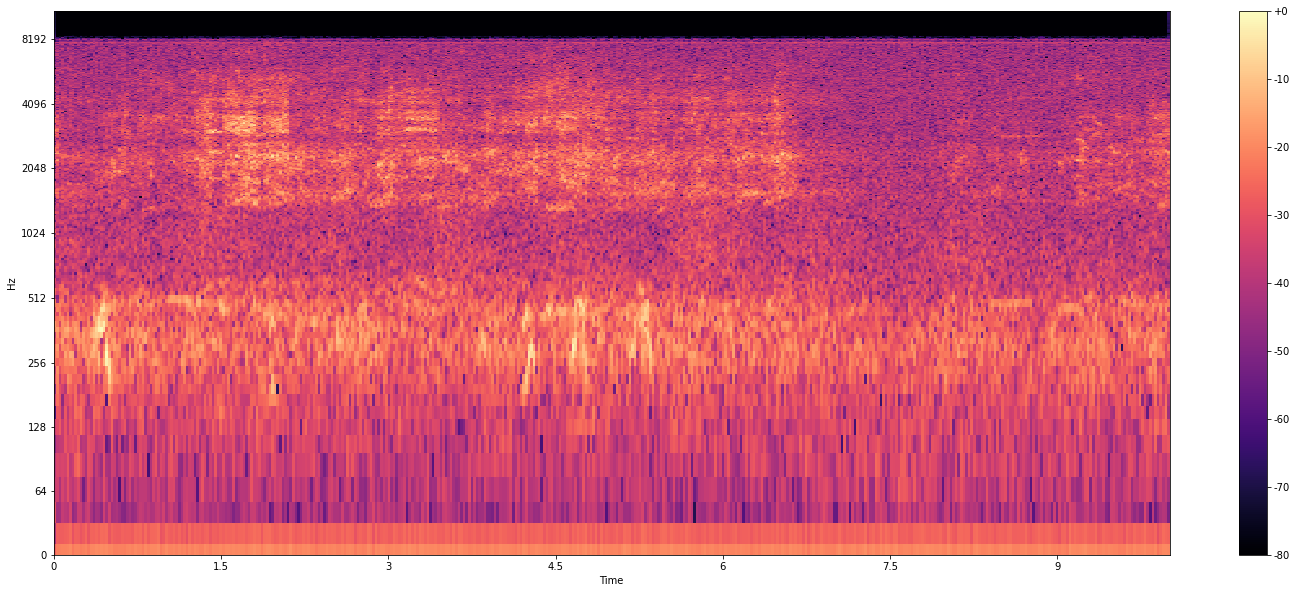

In [10]:
Y = librosa.power_to_db(np.abs(df["stft"][0]) ** 2, ref=np.max)  # 0 50 400
plot_spectrogram(Y, 22050, HOP_LENGTH, y_axis="log")

In [12]:
# create directories for chainsaw and others
for name in ("Chainsaw", "Others"):
    (SPEC_DIR / name).mkdir(parents=True, exist_ok=True)
    (MEL_SPEC_DIR / name).mkdir(parents=True, exist_ok=True)

In [13]:
%%capture
# create log power spectrogram
for name, segment_id, label, _, _, _, stft, _  in df.to_records(index=False):
    fig, ax = plt.subplots(figsize=(0.72, 0.72))
    y = librosa.power_to_db(stft ** 2)
    img = librosa.display.specshow(y, ax=ax, hop_length=HOP_LENGTH, sr=SR, y_axis="log")
    ax.axis("off")
    if name != "Chainsaw":
        name = "Others"
    fig.savefig(SPEC_DIR / name / f"{segment_id}.jpg", dpi=400, bbox_inches="tight", pad_inches=0)
    fig.clear()

print("done")

In [14]:
%%capture
# create melspectrogram
MEL_SPEC_DIR = IMAGE_DIR / "melspectrogram"
for name, segment_id, label, _, _, _, _, mel  in df.to_records(index=False):
    fig, ax = plt.subplots(figsize=(0.72, 0.72))
    librosa.display.specshow(librosa.power_to_db(mel, ref=np.max))
    ax.axis("off")
    if name != "Chainsaw":
        name = "Others"
    fig.savefig(MEL_SPEC_DIR / name / f"{segment_id}.jpg", dpi=400, bbox_inches="tight", pad_inches=0)
    fig.clear()

print("done")

In [15]:
def build_model(input_shape):
    """Return CNN model
    input_shape (tuple): Shape of input set
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    #model.add(keras.layers.Dense(len(NAMES), activation='softmax'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

# Train using log power spectrogram

In [17]:
# rgb range is [0, 255]. Rescale will bring this to [0, 1]
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [18]:
img_height = img_width = 224
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    SPEC_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training")

validation_generator = train_datagen.flow_from_directory(
    SPEC_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation")

Found 1450 images belonging to 2 classes.
Found 362 images belonging to 2 classes.


In [19]:
model = build_model((img_height, img_width, 3))

2021-11-14 19:01:50.501014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-14 19:01:50.502735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-14 19:01:50.503664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 32)        4

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

In [22]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs=10)

2021-11-14 19:01:50.812959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-14 19:01:50.851728: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3499910000 Hz


Epoch 1/10
45/45 [==============================] - 140s 3s/step - loss: 1.5190 - accuracy: 0.7725 - val_loss: 0.4875 - val_accuracy: 0.7557
Epoch 2/10
45/45 [==============================] - 139s 3s/step - loss: 0.4320 - accuracy: 0.8808 - val_loss: 0.7055 - val_accuracy: 0.7557
Epoch 3/10
45/45 [==============================] - 138s 3s/step - loss: 0.3954 - accuracy: 0.8922 - val_loss: 1.9548 - val_accuracy: 0.7614
Epoch 4/10
45/45 [==============================] - 137s 3s/step - loss: 0.2383 - accuracy: 0.9374 - val_loss: 1.0035 - val_accuracy: 0.7642
Epoch 5/10
45/45 [==============================] - 137s 3s/step - loss: 0.1898 - accuracy: 0.9442 - val_loss: 0.4731 - val_accuracy: 0.7727
Epoch 6/10
45/45 [==============================] - 136s 3s/step - loss: 0.2048 - accuracy: 0.9211 - val_loss: 2.0439 - val_accuracy: 0.7557
Epoch 7/10
45/45 [==============================] - 138s 3s/step - loss: 0.1334 - accuracy: 0.9384 - val_loss: 1.1243 - val_accuracy: 0.7614
Epoch 8/10
45

In [23]:
model.save("spec_model")

2021-11-14 19:24:44.847387: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: spec_model/assets


# Train using Mel Spectrograms

In [24]:
mel_train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

mel_train_generator = mel_train_datagen.flow_from_directory(
    MEL_SPEC_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training")

mel_validation_generator = mel_train_datagen.flow_from_directory(
    MEL_SPEC_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation")

Found 1450 images belonging to 2 classes.
Found 362 images belonging to 2 classes.


In [25]:
mel_model = build_model((img_height, img_width, 3))
mel_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

In [26]:
mel_model.fit_generator(
    mel_train_generator,
    steps_per_epoch=mel_train_generator.samples // batch_size,
    validation_data=mel_validation_generator, 
    validation_steps=mel_validation_generator.samples // batch_size,
    epochs=10)

Epoch 1/10
45/45 [==============================] - 137s 3s/step - loss: 1.9792 - accuracy: 0.7243 - val_loss: 0.5316 - val_accuracy: 0.7585
Epoch 2/10
45/45 [==============================] - 137s 3s/step - loss: 0.4598 - accuracy: 0.8225 - val_loss: 1.1960 - val_accuracy: 0.7670
Epoch 3/10
45/45 [==============================] - 136s 3s/step - loss: 0.2771 - accuracy: 0.8869 - val_loss: 0.5403 - val_accuracy: 0.7642
Epoch 4/10
45/45 [==============================] - 137s 3s/step - loss: 0.2592 - accuracy: 0.8753 - val_loss: 1.2064 - val_accuracy: 0.7670
Epoch 5/10
45/45 [==============================] - 136s 3s/step - loss: 0.2269 - accuracy: 0.9037 - val_loss: 0.9408 - val_accuracy: 0.7614
Epoch 6/10
45/45 [==============================] - 136s 3s/step - loss: 0.3159 - accuracy: 0.8935 - val_loss: 0.7467 - val_accuracy: 0.7727
Epoch 7/10
45/45 [==============================] - 136s 3s/step - loss: 0.2343 - accuracy: 0.9000 - val_loss: 0.8353 - val_accuracy: 0.7926
Epoch 8/10
45

In [27]:
mel_model.save("melspec_model")

INFO:tensorflow:Assets written to: melspec_model/assets
